In [1]:
%load_ext autoreload
%autoreload 2


%matplotlib inline
%cd C:\MAD4AG

from tqdm.auto import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

C:\MAD4AG


In [2]:
file = r'.\dbs\twins\03-15-schedule-0.pkl'

df_act_schedule_0 = pd.read_pickle(file)



## compare activity participation with SySMo model

In [3]:
df_act_schedule_0['dur']= df_act_schedule_0['h_e']-df_act_schedule_0['h_s']

df_act_schedule_0['purpose']= df_act_schedule_0['purpose'].str[0]


In [4]:
df_act_schedule_0['wt_i'] = df_act_schedule_0['wt'].round(0).astype(int)

newThis = pd.DataFrame(np.repeat(df_act_schedule_0.values, df_act_schedule_0['wt_i'].replace(0,1).tolist(), axis=0), columns=df_act_schedule_0.columns)

In [6]:
def cluster_tempo(pur=None, survey=None, interval=60, norm=True):
    """
    :param interval: resolution of temporal counting in minute, e.g., 30 min
    :type interval: int
    :param pur: Purpose to add to the activity
    :type pur: str
    :param survey: Input data from the survey
    :type survey: dataframe
    :return: A dataframe of half-hour frequency of a certain activity.

    """
    holder_size = int( 24 * (60 / interval))
    holder = np.zeros((holder_size, 1))

    temps=list(survey.loc[survey['purpose'] == pur, ['h_s', 'dur']].to_records(index=False))
    #number_ppl= len(survey[survey.purpose==pur].sub_id.unique())
    number_ppl= len(survey.sub_id.unique())

    for tm in temps:
        start_ = int(np.floor(tm[0] / interval))
        end_ = int(np.floor((tm[0]+ int(tm[1])) / interval))
        holder[start_:end_ + 1, 0] += 1

    #print(holder)

    holder_day = holder
    df = pd.DataFrame()
    df.loc[:, 'time'] = range(0, len(holder_day))
    df.loc[:, 'freq'] = holder_day
    if norm:
        df['freq'][df['freq']>number_ppl]= number_ppl
        df.loc[:, 'freq'] /= number_ppl
    if pur is not None:
        df.loc[:, 'activity'] = pur
    return df

In [7]:
home = cluster_tempo( survey=newThis, pur='H', interval=60, norm=False )

work = cluster_tempo( survey=newThis, pur='W', interval=60, norm=False )
other = cluster_tempo( survey=newThis, pur='O', interval=60, norm=False )


In [8]:
#combined_df['wt'].round(0).sum()

In [9]:
home['freq'] = home['freq']/ 7439553
work['freq'] = work['freq']/ 7439553
other['freq'] = other['freq']/ 7439553


In [10]:
df_survey_tempo = [home, work,other]

df_survey_tempo = pd.concat(df_survey_tempo)

df_survey_tempo = df_survey_tempo.pivot(index='activity', columns='time', values='freq')

In [11]:
survey_frequency = pd.read_csv('dbs/intermediate/act_temporal_pattern.csv', index_col='activity')

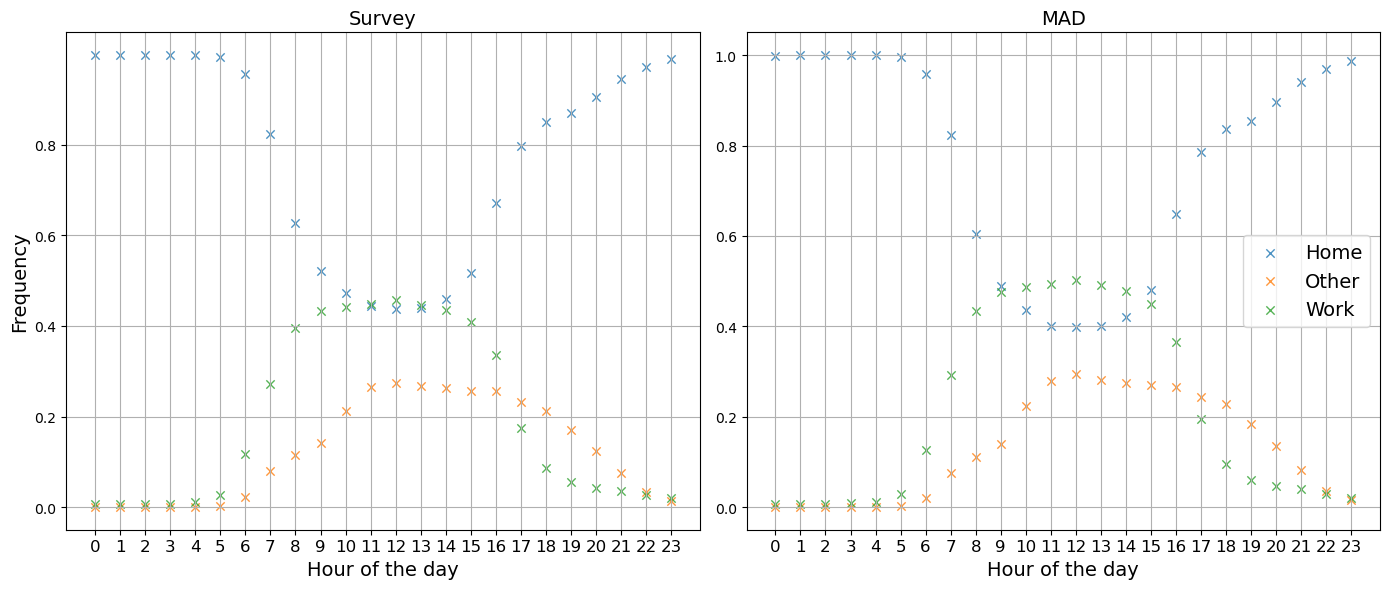

In [39]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (14, 6), layout="tight")

ax0.scatter(range(0,24), survey_frequency.loc['Home', :].values.tolist(), label='Home', marker='x', alpha=0.8,linewidths=1)
ax0.scatter(range(0,24), survey_frequency.loc['Other', :].values.tolist(), label='Other', marker='x', alpha=0.8,linewidths=1)
ax0.scatter(range(0,24), survey_frequency.loc['Work/School', :].values.tolist(), label='Work', marker='x', alpha=0.8,linewidths=1)

ax0.set_xlabel('Hour of the day', fontsize=14)
ax0.set_ylabel('Frequency', fontsize=14)
ax0.set_title('Survey', fontsize=14)
ax0.set_xticks(range(0,24,1),range(0,24,1), fontsize=12)  # Generate labels from 1 to 24
ax0.set_yticks(np.round(np.arange(0, 1, step=0.2),2), fontsize=12)
ax0.grid()

ax1.scatter(range(0,24), df_survey_tempo.loc['H', :].values.tolist(), label='Home', marker='x', alpha=0.8,linewidths=1)
ax1.scatter(range(0,24), df_survey_tempo.loc['O', :].values.tolist(), label='Other', marker='x', alpha=0.8,linewidths=1)
ax1.scatter(range(0,24), df_survey_tempo.loc['W', :].values.tolist(), label='Work', marker='x', alpha=0.8,linewidths=1)

ax1.set_xlabel('Hour of the day', fontsize=14)
ax1.set_title('MAD', fontsize=14)
ax1.set_xticks(range(0,24,1),range(0,24,1), fontsize=12)  # Generate labels from 1 to 24
ax1.grid()

plt.legend(fontsize=14, frameon=True, loc='center right')
plt.savefig('figures/temporal_visitation_pattern_MAD_Survey.png', dpi=300, bbox_inches="tight")


plt.show()


## compare activity participation with SySMo model

In [13]:
df_syn_act_plan = pd.read_pickle(
    r'C:\Synthetic_population\code\new_synthetic_sweden\output\synthetic_population\df_act_plan.pkl')
syn_pop_all = pd.read_pickle(
    r'C:\Synthetic_population\code\new_synthetic_sweden\output\synthetic_population\syn_pop_all.pkl')

adult_list = syn_pop_all['PId'][syn_pop_all.age > 17].unique()
df_syn_act_plan = df_syn_act_plan[df_syn_act_plan.PId.isin(adult_list)]

In [26]:
for purp in [6,4,10, 1] :
    if purp == 4 :
        purpose = 'work'
    elif purp == 6 :
        purpose = 'school'
    elif purp == 10 :
        purpose = 'other'
    elif purp == 1 :
        purpose = 'home'

    vars()['df_syn_act_plan_'+purpose] = pd.read_pickle( r'C:\Synthetic_population\code\new_synthetic_sweden\Validation\Results\a_engagement_by_hours'+purpose+'.pkl')

    vars()['df_syn_act_plan_'+purpose] = vars()['df_syn_act_plan_'+purpose][vars()['df_syn_act_plan_'+purpose].PId.isin(adult_list)]

In [28]:
df_syn_act_plan_work = pd.concat([df_syn_act_plan_work, df_syn_act_plan_school], ignore_index=True)

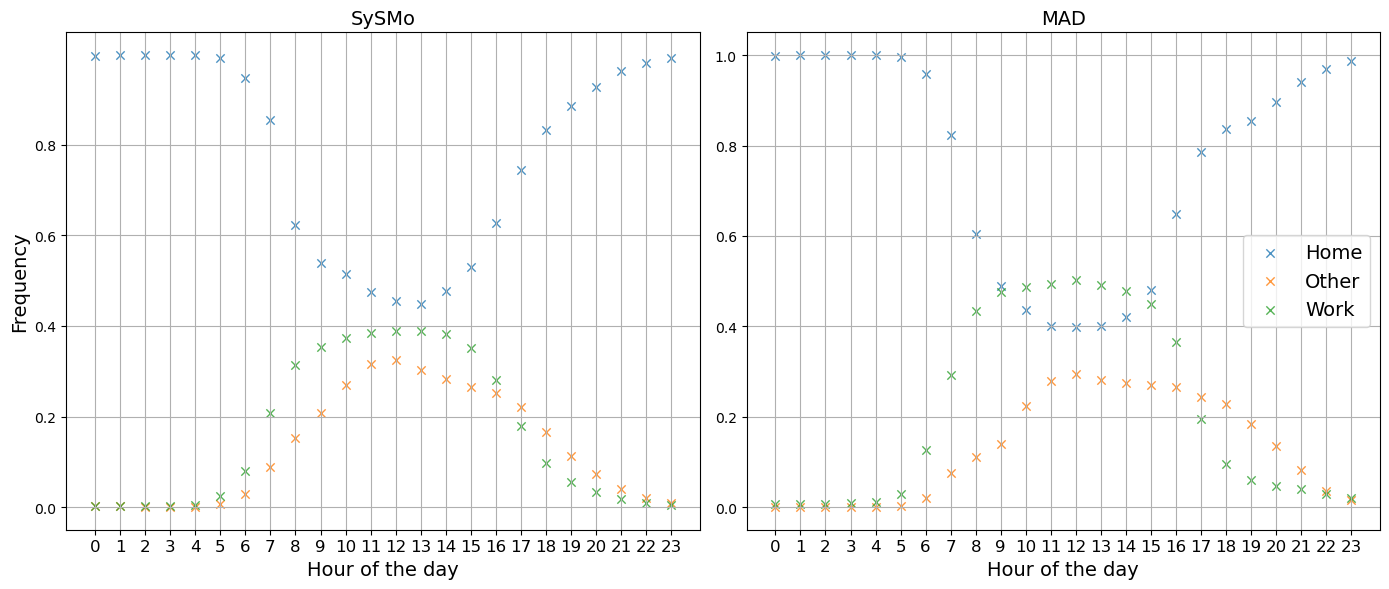

In [38]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (14, 6), layout="tight")



for purpose in [ 'home','other','work']:


    vars()[purpose+'_sum'] = vars()['df_syn_act_plan_'+purpose].work_all.sum(axis=0)


    vars()[purpose+'_sum_'] = np.concatenate((vars()[purpose+'_sum'][21:], vars()[purpose+'_sum'][:21]))

    ax0.scatter(range(24),vars()[purpose+'_sum_']/len(adult_list), label=purpose, marker='x', alpha=0.8,linewidths=1)



ax0.set_xlabel('Hour of the day', fontsize=14)
ax0.set_ylabel('Frequency', fontsize=14)
ax0.set_title('SySMo', fontsize=14)
ax0.set_xticks(range(0,24,1),range(0,24,1), fontsize=12)  # Generate labels from 1 to 24
ax0.set_yticks(np.round(np.arange(0, 1, step=0.2),2), fontsize=12)
ax0.grid()


ax1.scatter(range(0,24), df_survey_tempo.loc['H', :].values.tolist(), label='Home', marker='x', alpha=0.8,linewidths=1)
ax1.scatter(range(0,24), df_survey_tempo.loc['O', :].values.tolist(), label='Other', marker='x', alpha=0.8,linewidths=1)
ax1.scatter(range(0,24), df_survey_tempo.loc['W', :].values.tolist(), label='Work', marker='x', alpha=0.8,linewidths=1)

ax1.set_xlabel('Hour of the day', fontsize=14)
ax1.set_title('MAD', fontsize=14)
ax1.set_xticks(range(0,24,1),range(0,24,1), fontsize=12)  # Generate labels from 1 to 24
ax1.grid()

plt.legend(fontsize=14, frameon=True, loc='center right')
plt.savefig('figures/temporal_visitation_pattern_MAD_Syn.png', dpi=300, bbox_inches="tight")


plt.show()